<a href="https://colab.research.google.com/github/bdeazevedo82/IMF-publications/blob/main/IMF_pub_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***MASTER THESIS: IMF TECHNICAL PRODUCTION AND PRACTICE AFTER THE INTERNATIONAL FINANCIAL CRISIS ***

My Master thesis involved the analysis of hundreds of technical publications by the International Monetary Fund from 1998 to 2013. The objective was to find changes in technical messages and policy recommendations to member countries since the international financial crisis of 2008-2009.

At the IMF webpage there is information on all IMF publications since 1980, as well as the path to the electronic version for most of them. However, this information is not available on a database format, simply available through a list of web elements after a search action is performed, thus making it difficult and very time consuming to process and analyse. 

I therefore wrote a Python code to scrape the site and create an SQL database with the data, making it easily available for my analysis once all necessary searches are performed.

In this example, I simply use the tool to create an SQL database with all Article IV reports by the IMF staff during the years 2007 and 2013.

In [ ]:
!pip install selenium

     |████████████████████████████████| 904 kB 5.3 MB/s 


In [ ]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 40 not upgraded.
Need to get 86.0 MB of archives.
After this operation, 298 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 91.0.4472.101-0ubuntu0.18.04.1 [1,124 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 91.0.4472.101-0ubuntu0.18.04.1 [76.1 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 91.0.4472.101-0ubuntu0.1

Making available and importing necessary packages.

In [ ]:
import sqlite3 as db
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
import requests
import pandas as pd

In this example, using Selenium, I run two automated searches on the IMF publications' webpage, setting date dropdown to "During", inputing text "Article IV" into the title search and setting the year to 2007 in the first search and 2013 in the second.

In the original code, the user was able to input the year and the keyword to search in the title directly into the console.
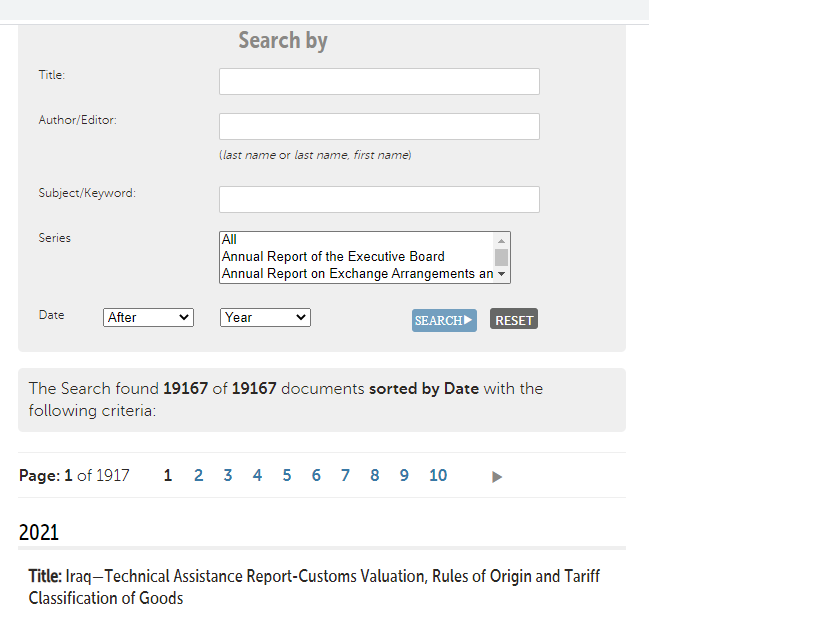

In [ ]:
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

driver.get("https://www.imf.org/en/publications/search")

drop_type = Select(driver.find_element_by_xpath('//*[@id="SeriesMultiSelect"]'))
drop_type.select_by_value("IMF Staff Country Reports")

title = driver.find_element_by_xpath('//*[@id="TitleInput"]')
title.send_keys("Article IV")

drop_time = Select(driver.find_element_by_xpath('//*[@id="DateWhenSelect"]'))
drop_time.select_by_visible_text("During")

drop_year = Select(driver.find_element_by_xpath('//*[@id="YearSelect"]'))
year = 2007
drop_year.select_by_value(str(year))

driver.find_element_by_xpath('//*[@id="SearchButton"]').click()
url = driver.current_url

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


I then save the new url from the search and use it to scrape the relevant information from the search result, in particular: title, series, date, download link and summary of findings.

Summary of findings and download link are provided inside each one of the publications' specific webpage, so it is necessary to access all of the publications' links to scrape that data.

The scraper was set to take into account different types of webpage structures, using the if, else, try and except commands.

All data is then cleaned and saved into a dictionary, showing the number of documents scraped.

In [ ]:
import re

npo_docs = {}
docn0 = 0

while True:
    data = requests.get(url).text
    soup = BeautifulSoup(data, 'html.parser')

    docs = soup.find_all("div", {"class":"result-row pub-row"})
    for doc in docs:
      title = doc.find("a").text.strip()
      series = doc.findAll("p")[1].text.strip()

      m = re.search("No. (.+)", series)
      if m:
          found = m.group(1)
      n = re.search("(.+)/", found)
      if n:
          found2 = n.group(1)
      o = re.search("/(.+)", found)
      if o:
          found3 = o.group(1)
      found4 = found2 + found3

      date = doc.findAll("p")[2].text.strip()
      link = "https://www.imf.org" + doc.find("a").get("href")

      doc_data = requests.get(link).text
      doc_soup = BeautifulSoup(doc_data, "html.parser")
      doc_soup_docs = doc_soup.findAll("section")[0]
      if len(doc_soup_docs.findAll("p", {"class":"pub-desc"})) == 3:
          doc_summary = doc_soup_docs.findAll("p", {"class":"pub-desc"})[2].text
          down_link = "N/A"
      else:
          try:
              down_link = "https://www.imf.org" + doc_soup_docs.find("a", {"class": "piwik_download"}).get("href")
              doc_summary = doc_soup_docs.findAll("p", {"class": "pub-desc"})[3].text
          except:
              doc_summary = doc_soup_docs.findAll("p", {"class": "pub-desc"})[3].text
              down_link = "N/A"


      docn0 += 1

      npo_docs[docn0] = [title, series, date, link, doc_summary, down_link, found4, int(year)]


    if soup.find("a", {"class":"next"}):
        url_tag = soup.find("a", {"class":"next"})
        url = url_tag.get("href")
    else:
        break

print("Total docs:", docn0)

Total docs: 114


With the dictionary, I create a dataframe using pandas and store the data into an SQL database, creating one table to store all the data on Article IV publications.

In [ ]:
npo_docs_df = pd.DataFrame.from_dict(npo_docs, orient='index', columns=["Title", "Series", "Date", "Link", "Summary", "Down_link", "Number", "Year"])

con = db.connect("imf_ArticleIVdocs.sqlite")
npo_docs_df.to_sql("docs", con=con, if_exists="replace")

con.commit()


I now run a second search to find all Article IV publications of the year 2013, and append the data to the same SQL table.

In [ ]:
driver.get("https://www.imf.org/en/publications/search")

drop_type.select_by_value("IMF Staff Country Reports")

title.send_keys("Article IV")

drop_time.select_by_visible_text("During")

year = 2013
drop_year.select_by_value(str(year))

driver.find_element_by_xpath('//*[@id="SearchButton"]').click()
url = driver.current_url

driver.close()

npo_docs = {}
docn0 = 0

while True:
    data = requests.get(url).text
    soup = BeautifulSoup(data, 'html.parser')

    docs = soup.find_all("div", {"class":"result-row pub-row"})
    for doc in docs:
      title = doc.find("a").text.strip()
      series = doc.findAll("p")[1].text.strip()

      m = re.search("No. (.+)", series)
      if m:
          found = m.group(1)
      n = re.search("(.+)/", found)
      if n:
          found2 = n.group(1)
      o = re.search("/(.+)", found)
      if o:
          found3 = o.group(1)
      found4 = found2 + found3

      date = doc.findAll("p")[2].text.strip()
      link = "https://www.imf.org" + doc.find("a").get("href")

      doc_data = requests.get(link).text
      doc_soup = BeautifulSoup(doc_data, "html.parser")
      doc_soup_docs = doc_soup.findAll("section")[0]
      if len(doc_soup_docs.findAll("p", {"class":"pub-desc"})) == 3:
          doc_summary = doc_soup_docs.findAll("p", {"class":"pub-desc"})[2].text
          down_link = "N/A"
      else:
          try:
              down_link = "https://www.imf.org" + doc_soup_docs.find("a", {"class": "piwik_download"}).get("href")
              doc_summary = doc_soup_docs.findAll("p", {"class": "pub-desc"})[3].text
          except:
              doc_summary = doc_soup_docs.findAll("p", {"class": "pub-desc"})[3].text
              down_link = "N/A"


      docn0 += 1

      npo_docs[docn0] = [title, series, date, link, doc_summary, down_link, found4, int(year)]


    if soup.find("a", {"class":"next"}):
        url_tag = soup.find("a", {"class":"next"})
        url = url_tag.get("href")
    else:
        break

npo_docs_df = pd.DataFrame.from_dict(npo_docs, orient='index', columns=["Title", "Series", "Date", "Link", "Summary", "Down_link", "Number", "Year"])

con = db.connect("imf_ArticleIVdocs.sqlite")
npo_docs_df.to_sql("docs", con=con, if_exists="append")

con.commit()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


This method allowed me to save enormous time for my thesis, as well as end up with a code that can be used to extract a novel database from the IMF.

In this example, I further use the Article IV newly constructed database to download all relevant Article IV documents to a specific folder.

In [ ]:
import os

directory = "Downloads"
parent_dir = "/content/"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

prefs = {"download.default_directory" : "/content/Downloads"}
chrome_options.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

for row in con.execute("SELECT Down_link FROM 'docs'"):
    link = str(row)
    m = re.search("'(.+?)'", link)
    if m:
        found = m.group(1)
    if found != "N/A":
        driver.get(found)

driver.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: use options instead of chrome_options
  # This is added back by InteractiveShellApp.init_path()


I then use the following code to search inside all the downloaded pdf documents for specific words. 

In my example, I run the code twice to find the following strings: "inequality" and "inclusive growth". You can choose to search any string using the console.

Information on the number of times the string is found in each document is stored in the database in a different easily relatable table for each search.

In [ ]:
!pip install PyPDF2

import PyPDF2
import os

dirs = os.listdir(path)

docs_imf = {}
filen0 = 0

search_keyword = input("Enter word: ")

for file in dirs:
    try:
        search_count = 0
        filen0 += 1
        pdfFileObj = open(path+"/"+file, 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        file_name = os.path.basename(pdfFileObj.name)
        m = re.search("_cr(.+?).pdf", file_name)
        if m:
            found = m.group(1)

        for page in range(0, pdfReader.numPages):
            pageObj = pdfReader.getPage(page)
            text = pageObj.extractText().encode("utf-8")
            search_text = text.lower().split()
            for word in search_text:
                if search_keyword in word.decode("utf-8"):
                    search_count += 1

        docs_imf[filen0] = [found, search_keyword, search_count]

        print("The word {} was found in {} file {} times".format(search_keyword, file, search_count))

    except:
        pass

docs_imf_df = pd.DataFrame.from_dict(docs_imf, orient='index', columns=["File name", "%s" %(search_keyword), "Number"])
con = db.connect("imf_ArticleIVdocs.sqlite")
docs_imf_df.to_sql("word_%s" %(search_keyword), con=con, if_exists="replace")
con.commit()

Enter word: inclusive


The word inclusive was found in _cr07132.pdf file 0 times
The word inclusive was found in _cr13367.pdf file 15 times
The word inclusive was found in _cr0750.pdf file 1 times
The word inclusive was found in _cr13251.pdf file 3 times
The word inclusive was found in _cr07335.pdf file 1 times
The word inclusive was found in _cr0751.pdf file 0 times
The word inclusive was found in _cr0792.pdf file 0 times
The word inclusive was found in _cr07217.pdf file 0 times
The word inclusive was found in _cr13198.pdf file 9 times
The word inclusive was found in _cr07350.pdf file 0 times
The word inclusive was found in _cr07205.pdf file 1 times
The word inclusive was found in _cr1334.pdf file 11 times
The word inclusive was found in _cr1387.pdf file 4 times
The word inclusive was found in _cr07268.pdf file 0 times
The word inclusive was found in _cr13197.pdf file 20 times
The word inclusive was found in _cr13215.pdf file 13 times
The word inclusive was found in _cr07380.pdf file 0 times
The word inclus

Finally, here is an example of the kind of analysis that I performed in my thesis with this newly constructed database, using Power BI.

Link to full Power BI report:
[IMF Article IV report](https://drive.google.com/drive/folders/1XPrCXxcPyQo8lyCNtl9BjNSlTQIZ1bhE?usp=sharing)

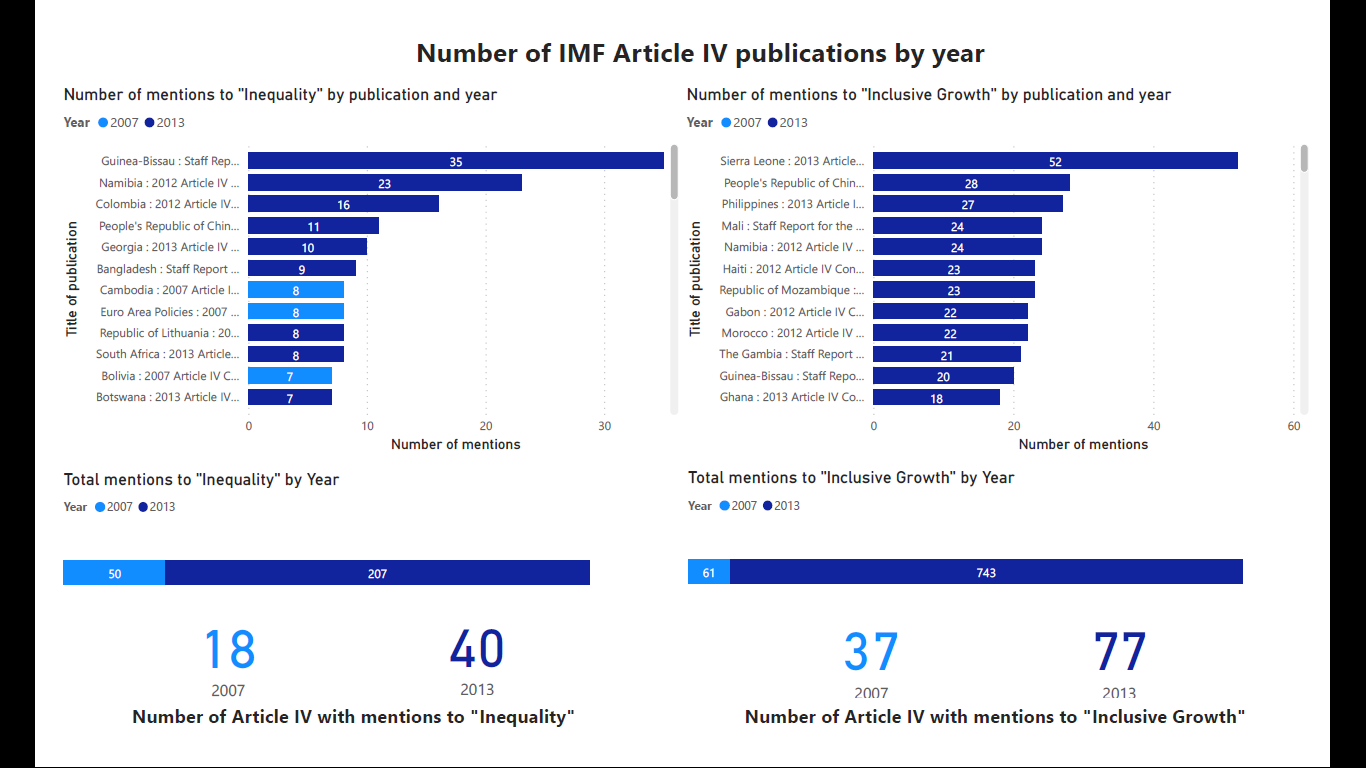

In the report, I simply show the number of instances of "inequality" and "inclusive growth" in 114 Article IV reports developed in 2007, prior to the international financial crisis, with the number of instances of the same terms in 117 Article IV reports developed in 2013, after the crisis.

As can be seen in the graphs, for both terms, the number of mentions is significantly higher in 2013 reports. While only 18 reports (from 114) included at least one mention to "inequality" in 2007, 40 reports (from 117) included mentions to "inequality" in 2013. Similarly, 37 included at least one mention to "inclusive growth" in 2007, compared to 77 in 2013.

The comparison is particularly striking using total number of mentions to "inclusive growth": 61 mentions in total in 2007 reports vs. 743 in 2013 reports.

This analysis was only one of many in my thesis that suggests changes in IMF technical and policy recommendations to member countries after the international crisis.